In [4]:
from citalopram_project.load import load_neurons
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
neurons = load_neurons().dropna().assign(group=lambda x: pd.Categorical(x.group, categories=["sal", "continuation", "discontinuation"], ordered=True))


C:\Users\roryl\.conda\envs\citalopram\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


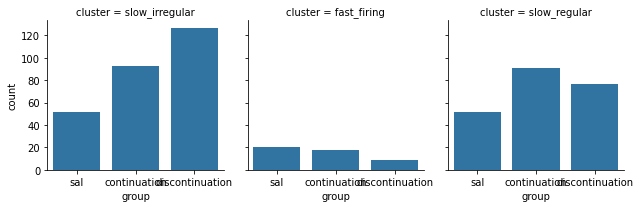

In [31]:
g = sns.FacetGrid(neurons, col="cluster")
g.map(sns.countplot, "group",)

C:\Users\roryl\.conda\envs\citalopram\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


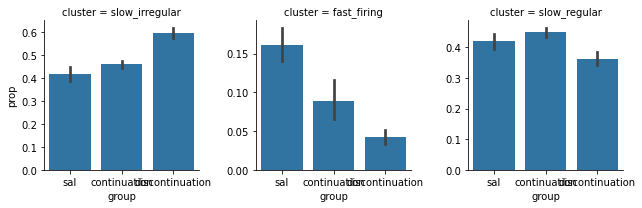

In [39]:
import pandas as pd
def prop_stats(df, cnames):
    out = {}
    for cname in cnames:
        out[cname] = (df["cluster"] == cname).mean()
    return pd.Series(out)

cnames = neurons.cluster.unique()

g = (
    neurons
    .groupby("session_name", as_index=False)
    .apply(prop_stats, cnames=cnames)
    .melt(id_vars="session_name", var_name="cluster", value_name="prop")
    .merge(neurons[["session_name", "group"]])
    .pipe(sns.FacetGrid, col="cluster", sharey=False, )
)
g.map(sns.barplot, "group", "prop",)

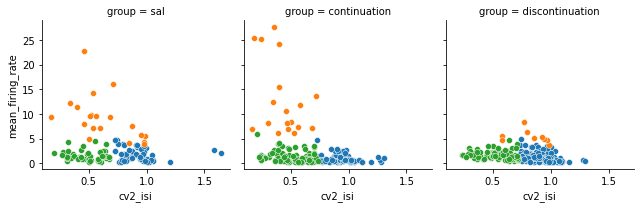

In [38]:
g = sns.FacetGrid(data=neurons, col="group", hue="cluster")
g.map(sns.scatterplot, "cv2_isi", "mean_firing_rate")

In [45]:
from citalopram_project.load import load_spikes

spikes = load_spikes("pre")
neurons = load_neurons().dropna()



In [49]:
def prop_stats(df, cnames):
    out = {}
    for cname in cnames:
        out[cname] = (df["cluster"] == cname).mean()
    return pd.Series(out)

cnames = neurons["cluster"].unique()
neurons.loc[lambda x: x.group=="sal"].groupby("session_name").apply(prop_stats, cnames).sort_values("slow_regular", ascending=False)

,slow_irregular,fast_firing,slow_regular
session_name,,,
hamilton_19,0.318182,0.136364,0.545455
hamilton_13,0.272727,0.272727,0.454545
hamilton_07,0.478261,0.108696,0.413043
chronic_09,0.125000,0.625000,0.250000
hamilton_01,0.800000,0.066667,0.133333


In [51]:
from spiketimes.df.conversion import df_to_list
from spiketimes.plots import grouped_raster

def get_spiketrains_by_categories(df_spikes):
    """
    Separate out a dataframe of spike times into 3 lists of spiketrains, one for each
    neuron group.
    
    Returns:
        SR, SIR, FF
    """
    _, slow_regs = df_to_list(df_spikes[df_spikes["cluster"] == "slow_regular"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

    _, slow_irregs = df_to_list(df_spikes[df_spikes["cluster"] == "slow_irregular"],
                   spiketimes_col="spiketimes",
                   spiketrain_col="neuron_id")

    _, ffs = df_to_list(df_spikes[df_spikes["cluster"] == "fast_firing"],
                   spiketimes_col="spiketimes",
                   spiketrain_col="neuron_id")
    return slow_regs, slow_irregs, ffs

def plot_raster_by_group(slow_regs, slow_irregs, ffs, t_start, num_secs, ax):
    """
    Given 3 lists of spiketrains (one per neuron group), plots a raster plot
    with spiketrains grouped and colored by group.
    """
    t_stop = t_start + num_secs
    ax = grouped_raster([slow_regs, slow_irregs, ffs],
                        ["#332288", "#CC6677",  "#117733"],
                   t_start=t_start, t_stop=t_stop,
                        space_between_groups=1,
                   plot_kwargs={"s":90},
                       ax=ax)
    ax.set_yticklabels([])
    ax.set_xticks(ticks=[t_start, t_start+5, t_start+10])
    ax.set(frame_on=False)
    ax.set_ylabel("Unit", fontsize=24)
    ax.set_xlabel("Time [sec]", fontsize=24)
    return ax

In [56]:
df_spikes = spikes.merge(neurons[["neuron_id", "session_name", "cluster"]]).loc[lambda x: x.session_name == "hamilton_19"]
slow_regs, slow_irregs, ffs = get_spiketrains_by_categories(df_spikes)

<AxesSubplot:xlabel='Time [sec]', ylabel='Unit'>

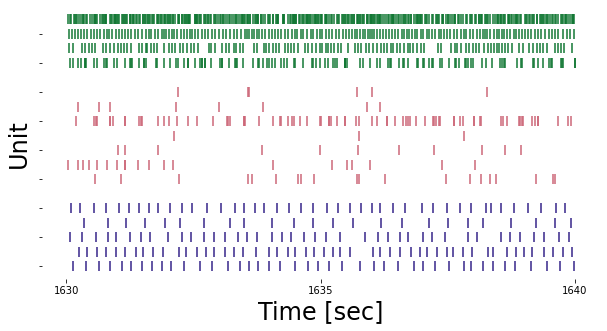

In [118]:
_, ax = plt.subplots(figsize=(10, 5))

s = [s for i, s in enumerate(slow_regs) if i in [0,  4, 5, 9,  20]]
plot_raster_by_group(
    s,
    slow_irregs[::2],
    ffs[:-2], 
    t_start=1630,
    num_secs=10,
    ax=ax
)